# Large-Scale Overlapping Genes Analysis (Refined Convergence + Visuals)

This notebook refines the stability landscape analysis.

**Metrics:**
1.  **Final Energy Distance (`Dist`)**: Baseline metric (Final Energy - Natural Mean).
2.  **Minimum Energy Distance (`Min_Dist`)**: The closest the simulated energy gets to the natural mean energy.
3.  **Iterations to Convergence (`Iter_Converged`)**: The iteration number at which the simulated energy first comes **within 1 standard deviation** of the natural mean.

**Pipeline:**
1.  **Temperature Optimization**: Load pre-calculated optimal temperatures.
2.  **Pairwise Scan**: Run overlap simulations capturing energy history (`whentosave=0.01`).
3.  **Analysis**: Calculate metrics.
4.  **Visualization**: Generate customized heatmaps (Seaborn).

In [1]:
# --- IMPORTS ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pandas as pd
import glob
import time
import json

# Add current directory to path to import overlappingGenes
sys.path.append(os.getcwd())
import overlappingGenes as og

plt.style.use('seaborn-v0_8-whitegrid')

## Parameters

Configure overlap ranges and reading frames here. All scan parameters are in the next cell.

In [2]:
# =============================================================================
# PARAMETERS - Configure your scan here
# =============================================================================

# --- OVERLAP CONFIGURATION ---
# Option 1: Specify exact overlaps as a list (any values you want)
# OVERLAPS = [12, 18, 24, 30, 36, 42, 48, 54, 60]

# Option 2: Use a range (start, stop, step)
# OVERLAPS = list(range(12, 91, 3))  # 12 to 90 in steps of 3

# Option 3: Reading frame specific overlaps
# Reading frames are determined by overlap mod 3:
#   - Frame 0 (in-frame):     overlap % 3 == 0  -> 12, 15, 18, 21, 24...
#   - Frame +1 (shifted +1):  overlap % 3 == 1  -> 13, 16, 19, 22, 25...
#   - Frame +2 (shifted +2):  overlap % 3 == 2  -> 14, 17, 20, 23, 26...

def generate_overlaps(start=12, stop=90, reading_frames=[0, 1, 2]):
    """
    Generate overlap values for specified reading frames.
    
    Parameters:
    -----------
    start : int
        Minimum overlap (nucleotides). Must be >= 6.
    stop : int
        Maximum overlap (nucleotides, exclusive).
    reading_frames : list of int
        Which reading frames to include. Options: 0, 1, 2
        - 0: In-frame overlaps (divisible by 3)
        - 1: +1 frame shift
        - 2: +2 frame shift
        
    Returns:
    --------
    list : Sorted list of overlap values
    """
    overlaps = []
    for ov in range(start, stop):
        if ov % 3 in reading_frames:
            overlaps.append(ov)
    return sorted(overlaps)


# === CHOOSE YOUR OVERLAP CONFIGURATION HERE ===

# Example configurations (uncomment the one you want):

# All reading frames, 12-90nt:
OVERLAPS = range(12,96,6)
print(OVERLAPS)
# Only in-frame overlaps (frame 0):
# OVERLAPS = generate_overlaps(start=12, stop=90, reading_frames=[0])

# Only frame-shifted overlaps (+1 and +2):
# OVERLAPS = generate_overlaps(start=12, stop=90, reading_frames=[1, 2])

# Custom specific values:
# OVERLAPS = [12, 24, 36, 48, 60, 72, 84]

# Sparse sampling across all frames:
# OVERLAPS = [12, 13, 14, 24, 25, 26, 36, 37, 38, 48, 49, 50, 60, 61, 62]


# --- SIMULATION PARAMETERS ---
ITERATIONS = 250_000      # MC iterations per trial
N_TRIALS = 40             # Number of trials per overlap value
WHENTOSAVE = 0.01         # Save history every 1% of iterations


# --- PRINT CONFIGURATION ---
print("=" * 60)
print("SCAN CONFIGURATION")
print("=" * 60)
print(f"Overlaps to scan: {len(OVERLAPS)} values")
print(f"  Range: {min(OVERLAPS)} to {max(OVERLAPS)} nt")
print(f"  Reading frames included: {sorted(set(ov % 3 for ov in OVERLAPS))}")
print(f"  Values: {OVERLAPS[:10]}{'...' if len(OVERLAPS) > 10 else ''}")
print(f"\nSimulation: {ITERATIONS:,} iterations x {N_TRIALS} trials")
print("=" * 60)

range(12, 96, 6)
SCAN CONFIGURATION
Overlaps to scan: 14 values
  Range: 12 to 90 nt
  Reading frames included: [0]
  Values: range(12, 72, 6)...

Simulation: 250,000 iterations x 40 trials


 - Frame 0: overlap % 3 == 0 → 12, 15, 18, 21... (codons align)
  - Frame +1: overlap % 3 == 1 → 13, 16, 19, 22... (shifted by 1nt)
  - Frame +2: overlap % 3 == 2 → 14, 17, 20, 23... (shifted by 2nt)

In [3]:
# --- DATA LOADING ---

BASE_DIR = "bmDCA"
try:
    ALL_PF_DIRS = sorted([d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d)) and d.startswith("PF")])
    print(f"Found {len(ALL_PF_DIRS)} Protein Families: {ALL_PF_DIRS}")
except FileNotFoundError:
    print(f"Error: Base directory '{BASE_DIR}' not found.")
    ALL_PF_DIRS = []

# Cache for parameters to avoid reloading 66 times
PARAMS_CACHE = {}
NATURAL_STATS_CACHE = {}

def get_params_and_stats(pf_name):
    if pf_name in PARAMS_CACHE:
        return PARAMS_CACHE[pf_name], NATURAL_STATS_CACHE[pf_name]
    
    # Load DCA Params
    param_file = os.path.join(BASE_DIR, pf_name, f"{pf_name}_params.dat")
    J, h = og.extract_params(param_file)
    PARAMS_CACHE[pf_name] = [J, h]
    
    # Load Natural Stats
    nat_file = os.path.join(BASE_DIR, pf_name, f"{pf_name}_naturalenergies.txt")
    energies = og.load_natural_energies(nat_file)
    NATURAL_STATS_CACHE[pf_name] = (np.mean(energies), np.std(energies))
    
    return [J, h], (np.mean(energies), np.std(energies))

Found 12 Protein Families: ['PF00004', 'PF00041', 'PF00072', 'PF00076', 'PF00096', 'PF00153', 'PF00271', 'PF00397', 'PF00512', 'PF00595', 'PF02518', 'PF07679']


In [4]:
# --- 1. LOAD OPTIMAL TEMPERATURES ---

OPTIMAL_TEMPS_FILE = "optimal_temperatures.json"
OPTIMAL_TEMPS = {}

if os.path.exists(OPTIMAL_TEMPS_FILE):
    print(f"Loading optimal temperatures from {OPTIMAL_TEMPS_FILE}...")
    with open(OPTIMAL_TEMPS_FILE, 'r') as f:
        OPTIMAL_TEMPS = json.load(f)
else:
    print("Warning: optimal_temperatures.json not found. Using default T=1.0 for all.")

print("Optimal Temps:", OPTIMAL_TEMPS)

Loading optimal temperatures from optimal_temperatures.json...
Optimal Temps: {'PF00004': 0.8666666666666667, 'PF00041': 1.0, 'PF00072': 1.0, 'PF00076': 0.8333333333333333, 'PF00096': 0.8666666666666667, 'PF00153': 0.8333333333333333, 'PF00271': 0.9333333333333333, 'PF00397': 0.8333333333333333, 'PF00512': 0.9666666666666666, 'PF00595': 0.8333333333333333, 'PF02518': 1.0666666666666667, 'PF07679': 0.8999999999999999}


In [ ]:
# --- 2. PAIRWISE SCAN WITH CONVERGENCE METRIC ---
# Uses global parameters: OVERLAPS, ITERATIONS, N_TRIALS, WHENTOSAVE

def run_pairwise_scan(pf_list, optimal_temps, overlaps=None):
    """
    Run pairwise overlap scan for all protein family combinations.
    
    Parameters:
    -----------
    pf_list : list
        List of protein family names
    optimal_temps : dict
        Dictionary of optimal temperatures per protein family
    overlaps : list, optional
        List of overlap values to scan. If None, uses global OVERLAPS.
    """
    # Use provided overlaps or fall back to global
    if overlaps is None:
        overlaps = OVERLAPS
    
    summary_data = []
    
    # Generate Pairs (Exclude self-pairs)
    pairs = []
    for i in range(len(pf_list)):
        for j in range(i + 1, len(pf_list)):
            pairs.append((pf_list[i], pf_list[j]))
            
    total_pairs = len(pairs)
    print(f"Starting Scan of {total_pairs} unique pairs...")
    print(f"Overlaps: {len(overlaps)} values from {min(overlaps)} to {max(overlaps)} nt")
    print(f"Reading frames: {sorted(set(ov % 3 for ov in overlaps))}")
    
    start_time_all = time.time()
    
    for idx, (pf1, pf2) in enumerate(pairs):
        pair_start = time.time()
        print(f"[{idx+1}/{total_pairs}] Scanning {pf1} vs {pf2}...")
        
        # Load Params
        params1, (nat_mean1, nat_std1) = get_params_and_stats(pf1)
        params2, (nat_mean2, nat_std2) = get_params_and_stats(pf2)
        
        t1 = optimal_temps.get(pf1, 1.0)
        t2 = optimal_temps.get(pf2, 1.0)
        
        len1 = len(params1[1]) // 21
        len2 = len(params2[1]) // 21
        
        # Filter overlaps that are valid for this pair
        max_overlap = min(len1, len2) * 3 - 6  # Safety buffer
        valid_overlaps = [ov for ov in overlaps if ov <= max_overlap]
        
        if len(valid_overlaps) < len(overlaps):
            print(f"   (Limiting to {len(valid_overlaps)} overlaps, max={max_overlap} for this pair)")
        
        for ov in valid_overlaps:
            trial_e1_final = []
            trial_e2_final = []
            
            trial_e1_min_dist = []
            trial_e2_min_dist = []
            
            trial_iter_conv_1 = []
            trial_iter_conv_2 = []
            
            for _ in range(N_TRIALS):
                init_seq = og.initial_seq_no_stops(len1, len2, ov, quiet=True)
                
                # Capture history based on WHENTOSAVE parameter
                # Returns: final_seq, accepted, hist1, hist2, final_energies, best_energies, best_seq
                result = og.overlapped_sequence_generator_int(
                    params1, params2, init_seq,
                    numberofiterations=ITERATIONS,
                    whentosave=WHENTOSAVE, 
                    quiet=True,
                    T1=t1, T2=t2
                )
                hist1 = result[2]
                hist2 = result[3]
                final_energies = result[4]
                e1, e2 = final_energies[0], final_energies[1]
                
                trial_e1_final.append(e1)
                trial_e2_final.append(e2)
                
                # --- CALCULATE METRICS ---
                # Distance Trajectories
                dists1 = np.abs(hist1 - nat_mean1)
                dists2 = np.abs(hist2 - nat_mean2)
                
                # 1. Minimum Distance Achieved
                min_d1 = np.min(dists1) if len(dists1) > 0 else abs(e1 - nat_mean1)
                min_d2 = np.min(dists2) if len(dists2) > 0 else abs(e2 - nat_mean2)
                
                trial_e1_min_dist.append(min_d1)
                trial_e2_min_dist.append(min_d2)
                
                # 2. Iterations to Convergence (Within 1 Standard Deviation)
                step_size = ITERATIONS * WHENTOSAVE
                
                # Seq 1 Convergence
                conv_idxs_1 = np.where(dists1 <= nat_std1)[0]
                if len(conv_idxs_1) > 0:
                    first_conv_idx = conv_idxs_1[0]
                    iter_conv_1 = (first_conv_idx + 1) * step_size
                else:
                    iter_conv_1 = ITERATIONS
                
                # Seq 2 Convergence
                conv_idxs_2 = np.where(dists2 <= nat_std2)[0]
                if len(conv_idxs_2) > 0:
                    first_conv_idx = conv_idxs_2[0]
                    iter_conv_2 = (first_conv_idx + 1) * step_size
                else:
                    iter_conv_2 = ITERATIONS
                
                trial_iter_conv_1.append(iter_conv_1)
                trial_iter_conv_2.append(iter_conv_2)
            
            # Save Summary (include reading frame info)
            # NOTE: Dist_1/Dist_2 now correctly compute mean of absolute distances
            # (abs first, then mean) to avoid cancellation when energies are 
            # above/below natural mean in different trials
            summary_data.append({
                'PF1': pf1, 'PF2': pf2, 'Overlap': ov,
                'Reading_Frame': ov % 3,  # 0, 1, or 2
                'Mean_E1': np.mean(trial_e1_final), 'Std_E1': np.std(trial_e1_final),
                'Mean_E2': np.mean(trial_e2_final), 'Std_E2': np.std(trial_e2_final),
                'Nat_Mean1': nat_mean1, 'Nat_Mean2': nat_mean2,
                'Nat_Std1': nat_std1, 'Nat_Std2': nat_std2,
                'Dist_1': np.mean(np.abs(np.array(trial_e1_final) - nat_mean1)),
                'Dist_2': np.mean(np.abs(np.array(trial_e2_final) - nat_mean2)),
                'Min_Dist_1': np.mean(trial_e1_min_dist),
                'Min_Dist_2': np.mean(trial_e2_min_dist),
                'Iter_Converged_1': np.mean(trial_iter_conv_1),
                'Iter_Converged_2': np.mean(trial_iter_conv_2)
            })
        
        pair_dur = time.time() - pair_start
        print(f"   -> Completed in {pair_dur:.1f}s")
            
    total_dur = time.time() - start_time_all
    print(f"\nFull Scan Complete in {total_dur/60:.1f} minutes!")
    return pd.DataFrame(summary_data)

In [6]:
# --- 3. RUN ANALYSIS ---

if 'ALL_PF_DIRS' in locals() and ALL_PF_DIRS:
    results_df = run_pairwise_scan(ALL_PF_DIRS, OPTIMAL_TEMPS)
    results_df.to_csv("large_scale_results_refined_std.csv")
    print("Results saved to large_scale_results_refined_std.csv")
else:
    print("No protein families found to scan. Check BASE_DIR.")

Starting Scan of 66 unique pairs...
Overlaps: 14 values from 12 to 90 nt
Reading frames: [0]
[1/66] Scanning PF00004 vs PF00041...


ValueError: too many values to unpack (expected 2)

In [ ]:
# --- 4. VISUALIZATION (SEABORN) ---

def plot_heatmap(df, metric='Dist_1', title_prefix="", vmax=None):
    # Create a new column 'Pair' for Y-axis labels
    df['Pair'] = df['PF1'] + ' - ' + df['PF2']
    
    # Pivot: Index=Pair, Columns=Overlap Limit, Values=Metric
    pivot = df.pivot_table(index='Pair', columns='Overlap', values=metric)
    
    plt.figure(figsize=(16, 20))
    sns.heatmap(pivot, 
                cmap="viridis_r", 
                vmax=vmax, 
                cbar_kws={'label': f'{metric}'})
    
    plt.title(f'Stability Landscape: All {len(pivot)} Gene Pairs ({title_prefix})', fontsize=16)
    plt.xlabel('Overlap Length (nt)', fontsize=12)
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

if 'results_df' in locals():
    print("Plotting: Final Energy Distance (Baseline)")
    plot_heatmap(results_df, metric='Dist_1', title_prefix="Baseline", vmax=50)
    
    print("Plotting: Minimum Energy Distance (Best State)")
    plot_heatmap(results_df, metric='Min_Dist_1', title_prefix="Best State", vmax=50)
    
    print("Plotting: Iterations to Convergence (Within 1 Std Dev)")
    plot_heatmap(results_df, metric='Iter_Converged_1', title_prefix="Convergence Speed", vmax=ITERATIONS)

Loaded results from large_scale_results_refined_std.csv
Plotting: Final Energy Distance (Baseline)


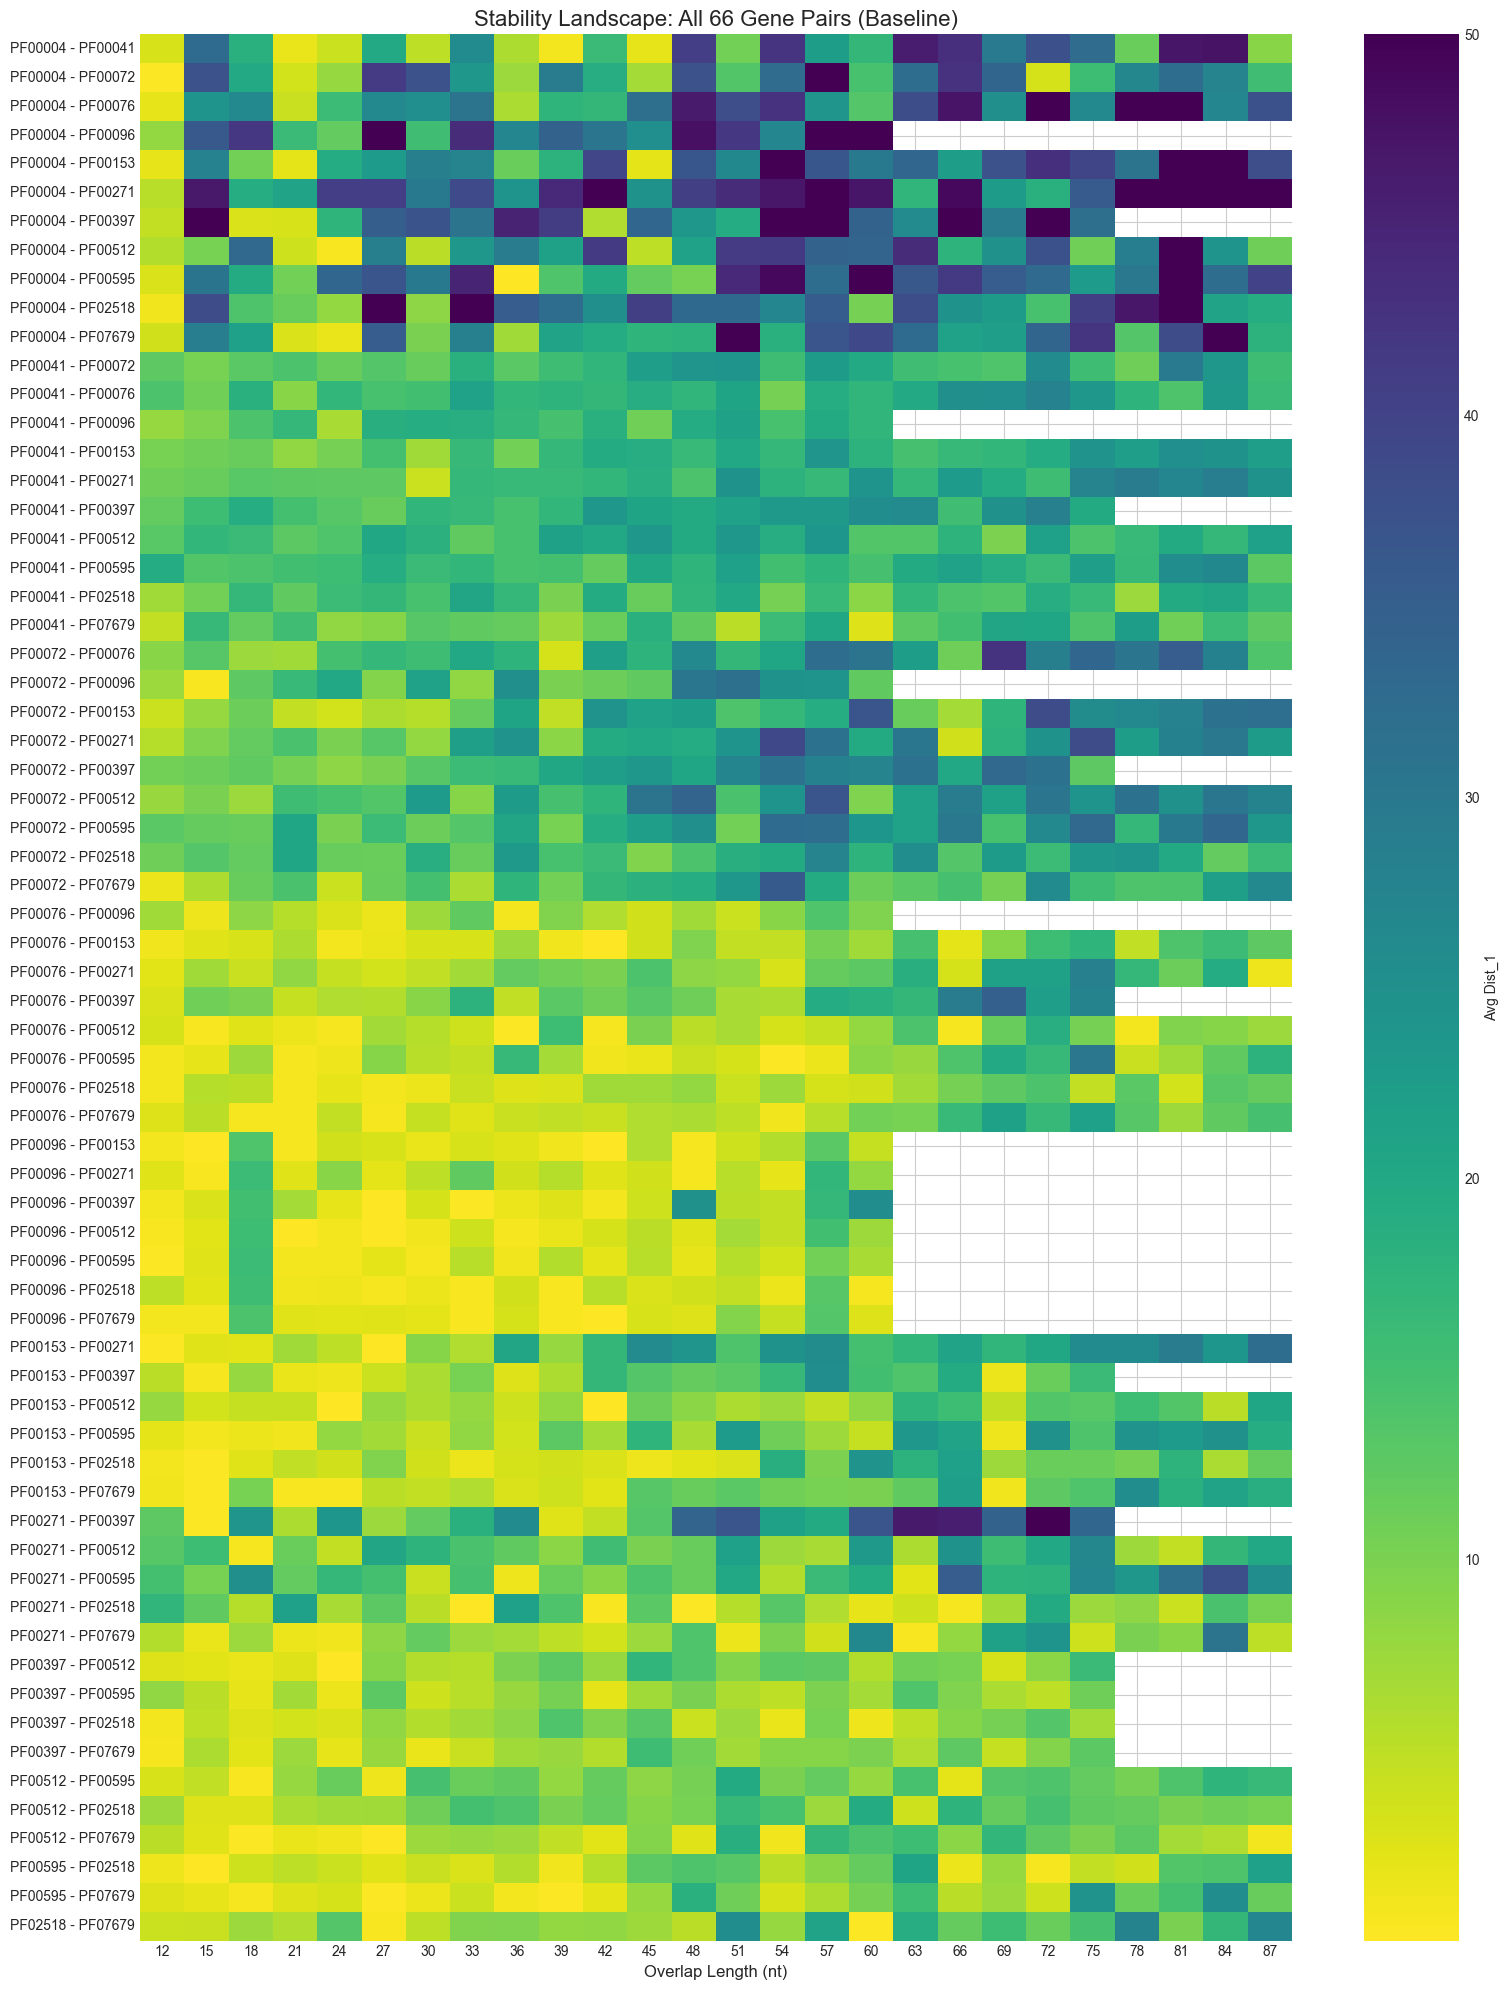

Plotting: Minimum Energy Distance (Best State)


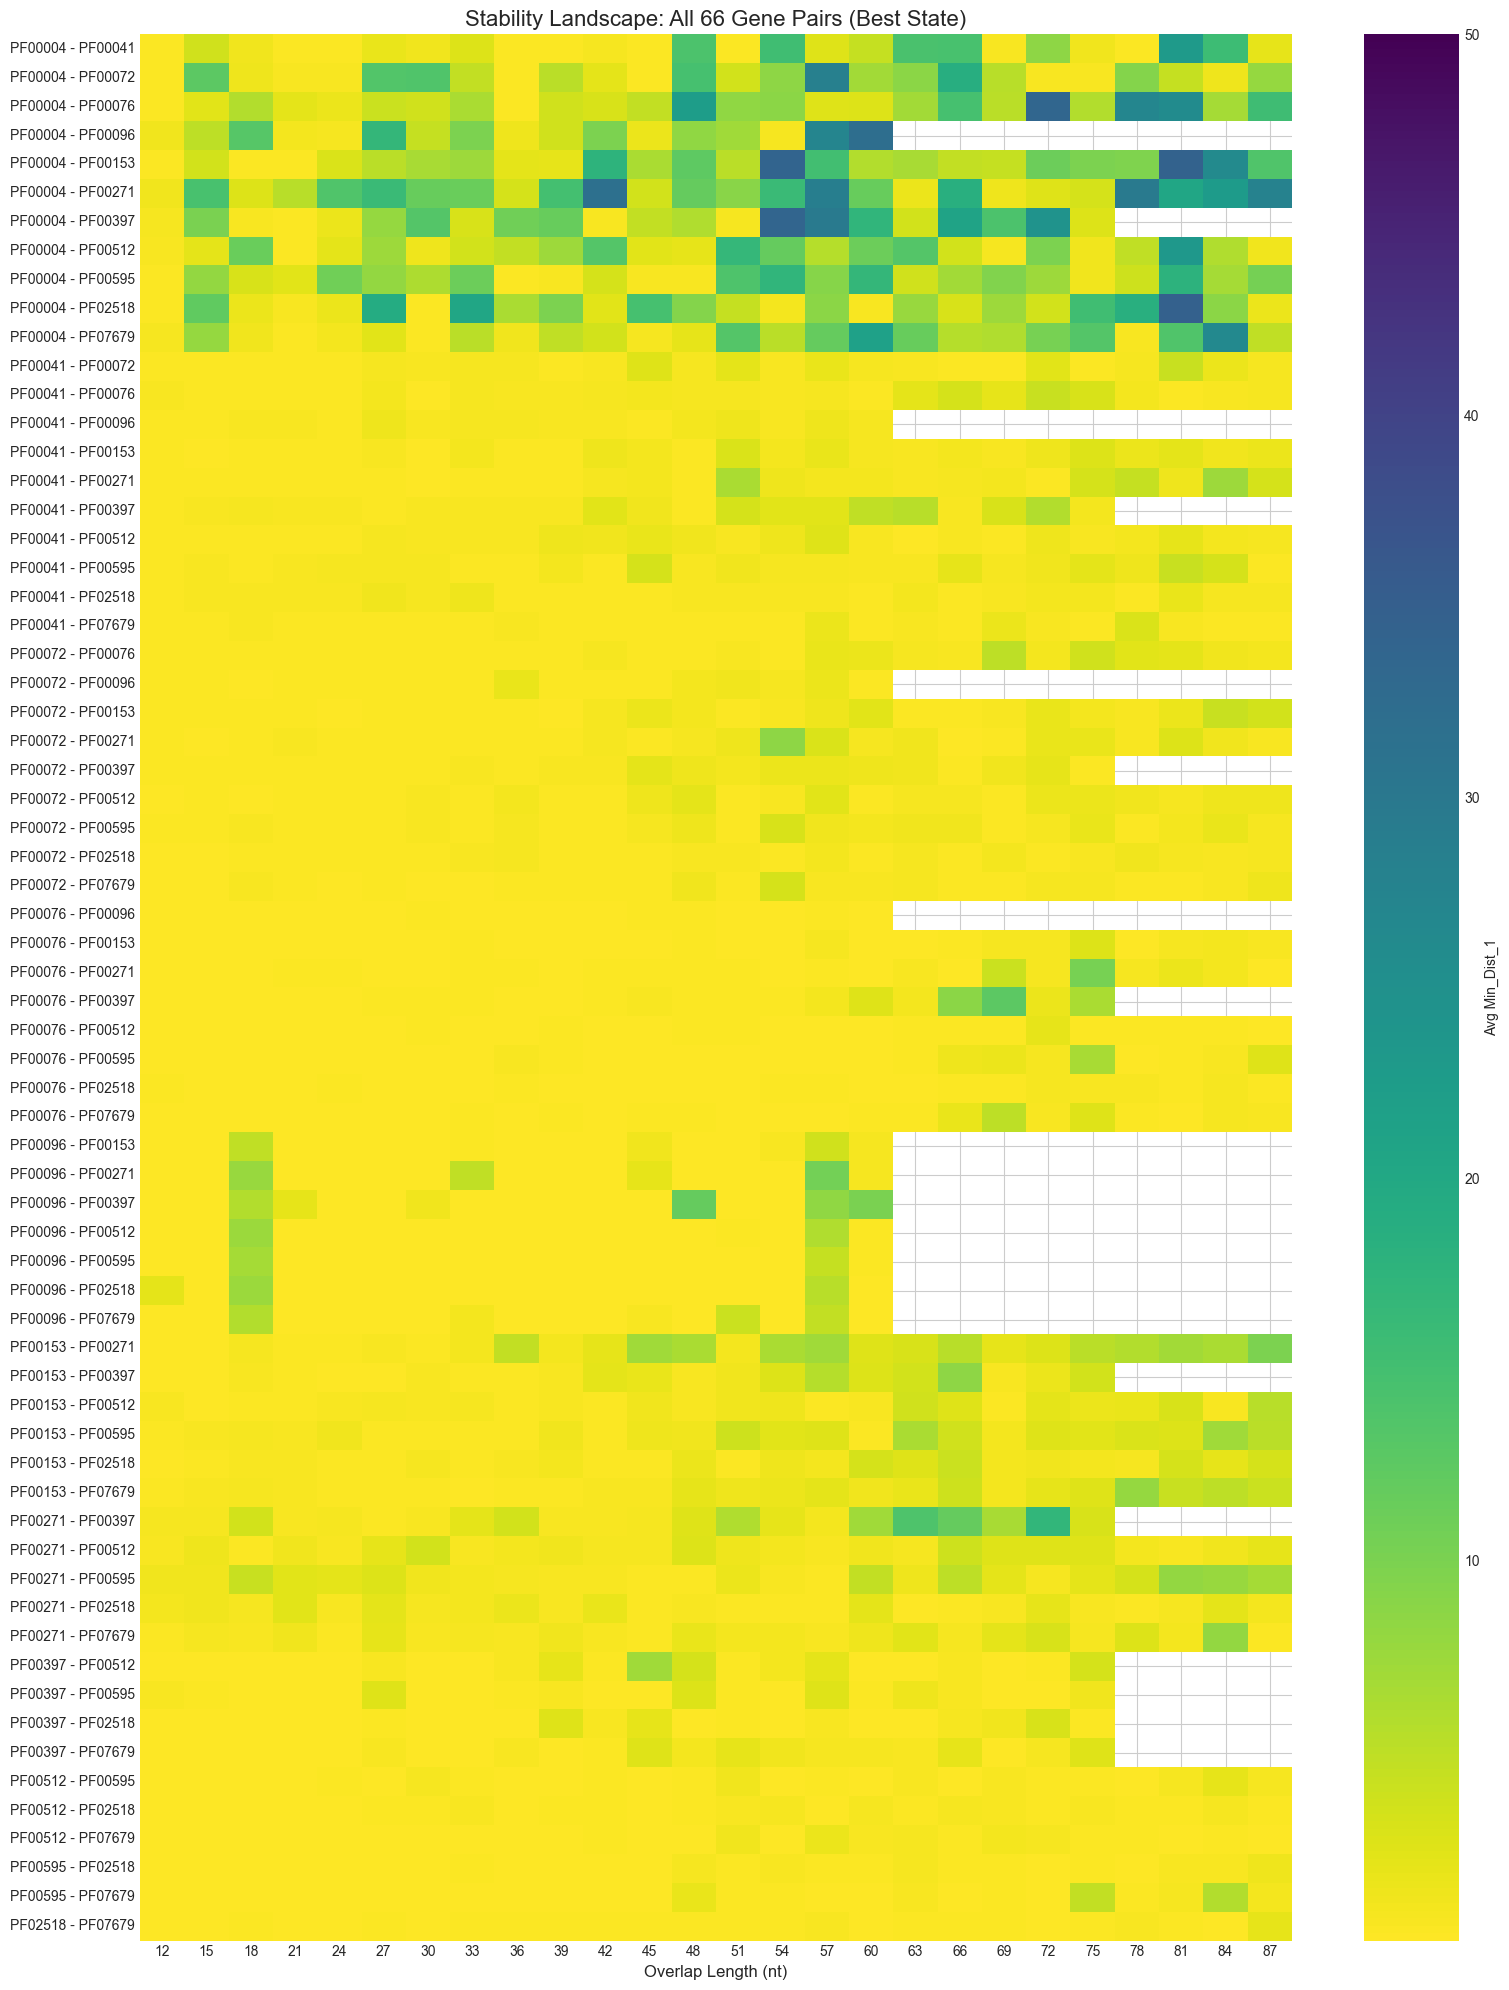

Plotting: Iterations to Convergence


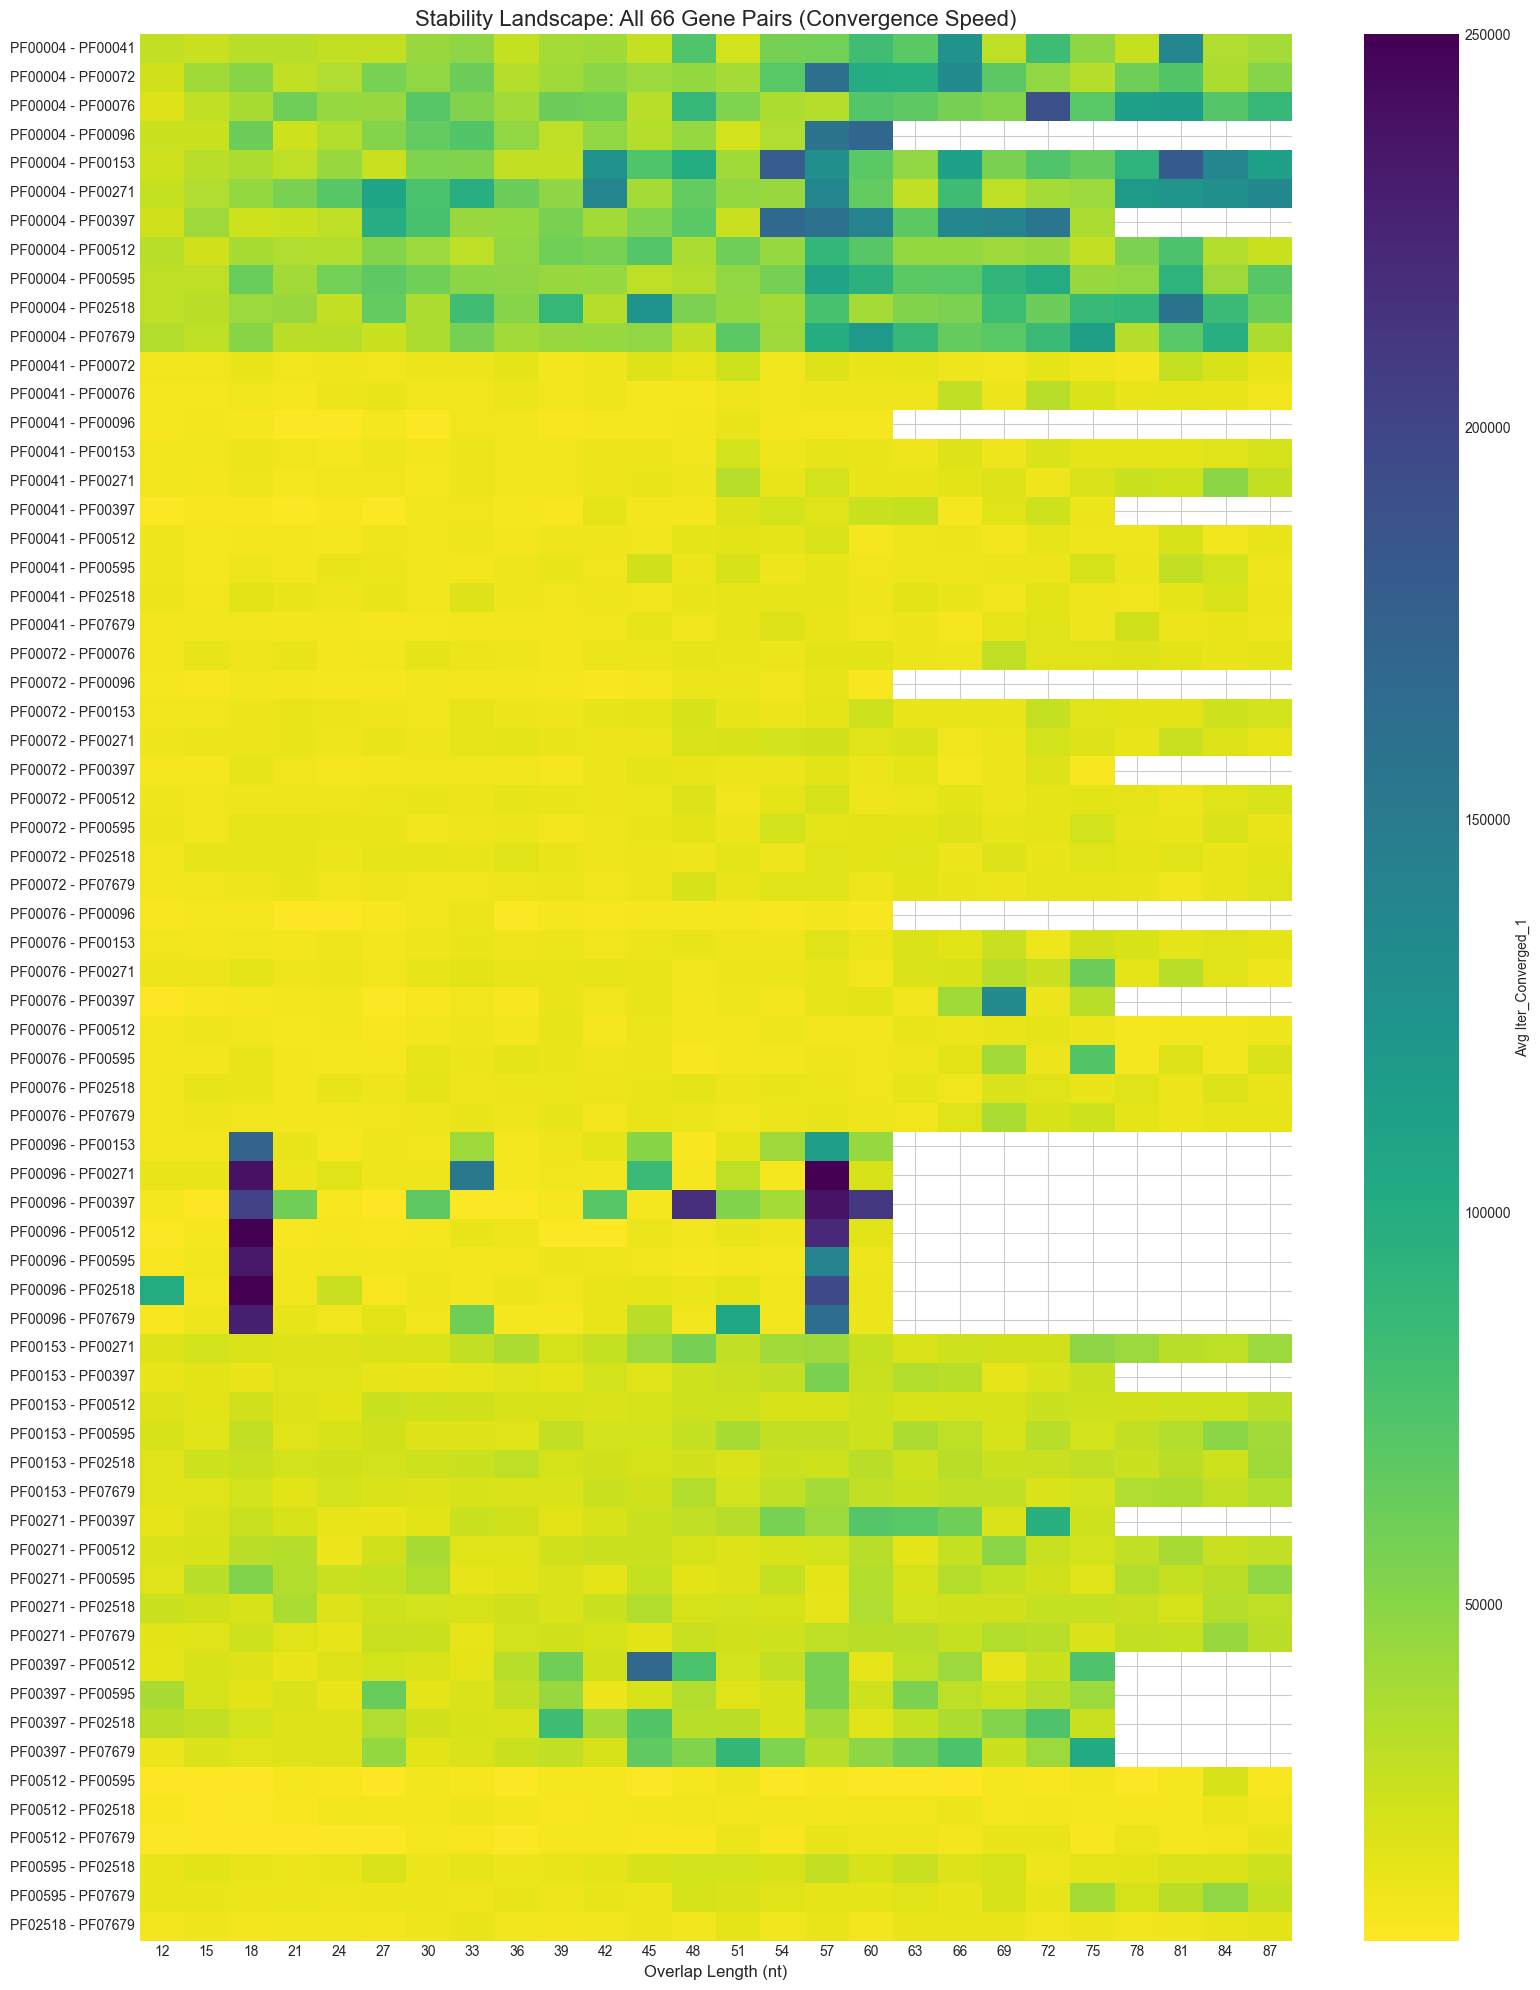

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 1. Load the Results
# Replace 'large_scale_results_refined_std.csv' with your actual results filename if different
results_file = "large_scale_results_refined_std.csv"

if os.path.exists(results_file):
    results_df = pd.read_csv(results_file)
    print(f"Loaded results from {results_file}")
    
    # 2. Define the Plotting Function
    def plot_heatmap_refined(df, metric, title_prefix="", vmax=None):
        # Create a new column 'Pair' for Y-axis labels
        df['Pair'] = df['PF1'] + ' - ' + df['PF2']
        
        # Pivot: Index=Pair, Columns=Overlap Limit, Values=Metric
        pivot = df.pivot_table(index='Pair', columns='Overlap', values=metric)
        
        plt.figure(figsize=(16, 20))
        sns.heatmap(pivot, 
                    cmap="viridis_r", 
                    vmax=vmax, 
                    cbar_kws={'label': f'Avg {metric}'})
        
        plt.title(f'Stability Landscape: All {len(pivot)} Gene Pairs ({title_prefix})', fontsize=16)
        plt.xlabel('Overlap Length (nt)', fontsize=12)
        plt.ylabel('') # Hide Y label as Pair names are enough
        plt.tight_layout()
        plt.show()

    # 3. Generate Plots
    print("Plotting: Final Energy Distance (Baseline)")
    plot_heatmap_refined(results_df, metric='Dist_1', title_prefix="Baseline", vmax=50)

    print("Plotting: Minimum Energy Distance (Best State)")
    plot_heatmap_refined(results_df, metric='Min_Dist_1', title_prefix="Best State", vmax=50)

    # Use a large vmax for iterations (e.g., 250,000) or let it auto-scale
    print("Plotting: Iterations to Convergence")
    plot_heatmap_refined(results_df, metric='Iter_Converged_1', title_prefix="Convergence Speed", vmax=250000)

else:
    print(f"Error: Could not find results file '{results_file}'. Please check the filename.")

MAKE SURE THE WAY THE DISTANCE IS CALCULATED SO THAT AVERAGE DOSTANCE DOESNT CANCEL AND GIVE 0 DISTANCE. LOOOK AT PHOTO OF WHITEBOARD